In [1]:
import numpy as np
import matplotlib
import matplotlib as mpl
from astropy.stats import LombScargle
from astropy.stats import sigma_clip
from scipy.stats import mode
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from astropy.io import fits
import h5py
import plotutils

import lightkurve 
from lightkurve import TessTargetPixelFile, TessLightCurveFile, TessLightCurve
from lightkurve.utils import plot_image

from lightkurve import MPLSTYLE

/home/tim/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=22              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

Populating the interactive namespace from numpy and matplotlib


In [3]:
fname = '../data/tess2018206045859-s0001-0000000029281992-0120-s_tp.fits.gz' #omega Capricorni

In [11]:
tpf = lightkurve.open(fname)
oldbks = tpf.flux_bkg

In [205]:
tpf.interact()

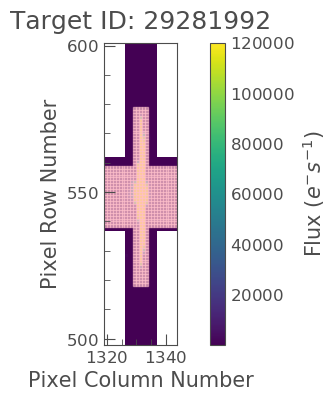

In [6]:
newmask = np.ones((tpf.flux.shape[1],tpf.flux.shape[2]),dtype='bool')

xx, yy = np.meshgrid(np.arange(newmask.shape[0]),np.arange(newmask.shape[1]))

# ymin = 90
# ymax = 100
# xmin = 5
# xmax = 18

# m1 = np.logical_or((xx>ymax).T,(xx<ymin).T)
# m2 = np.logical_or((yy>xmax).T,(yy<xmin).T)

# m3 = np.logical_or(m1,m2)

# newmask[m3] = False

ymin = 20
ymax = 80
ymin2 = 40
ymax2 = 60
xmin = 0
xmax = 24
xmin2 = 10
xmax2 = 14

m1 = np.logical_or((xx>ymax).T,(xx<ymin).T)
m2 = np.logical_or((yy>xmax).T,(yy<xmin).T)
m3 = np.logical_or((xx>ymax2).T,(xx<ymin2).T)
m4 = np.logical_or((yy>xmax2).T,(yy<xmin2).T)
m5 = np.logical_or(m1,m4)
m6 = np.logical_or(m2,m3)

m7 = np.logical_and(m5,m6)
# m8 = np.logical_and((rr>rmax).T,m7)
# # m6 = np.logical_or((yy>xmax2).T,(yy<xmin2).T)
# # m7 = np.logical_and(m5,m6)

newmask[m7] = False


tpf.plot(cadenceno=84023,aperture_mask=newmask)

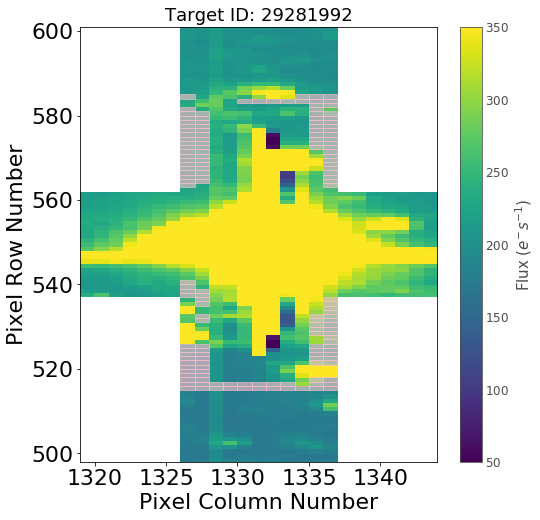

In [204]:
fig, ax = plt.subplots(figsize=(8,8))
tpf.plot(ax = ax, bkg=True, cadenceno=84023, scale='linear',vmin=50,vmax=350,aspect='auto',aperture_mask=tpf.background_mask)
# tpf.plot(ax = ax, bkg=True, cadenceno=84023, scale='linear',vmin=50,vmax=350,aspect='auto',aperture_mask=newmask)
plt.show()

In [122]:
# fig, ax = plt.subplots(figsize=(8,8))
# tpf.plot(ax = ax, bkg=False, cadenceno=84023, scale='linear',vmin=-50,vmax=50,aspect='auto')
# plt.show()

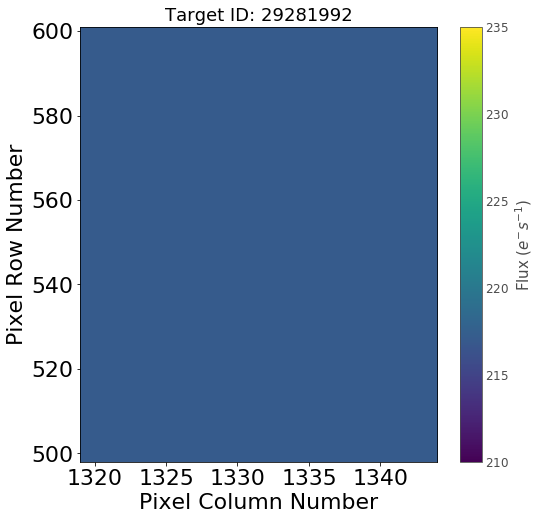

In [174]:
fig, ax = plt.subplots(figsize=(8,8))
plotutils.plot_bkg(tpf,ax = ax, cadenceno=84023, scale='linear',vmin=210,vmax=235,aspect='auto')
plt.show()

In [13]:
s1c1ccd4 = h5py.File('../data/sector001_camera1_ccd4.hdf5','r')

In [15]:
tpfcut = (tpf.row,tpf.row+tpf.shape[1],tpf.column,tpf.column+tpf.shape[2])

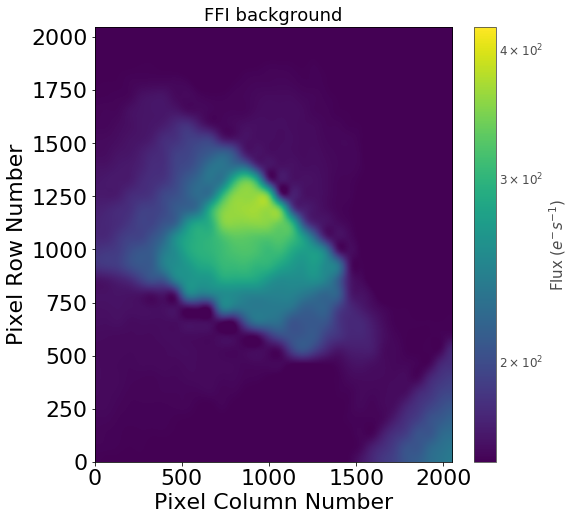

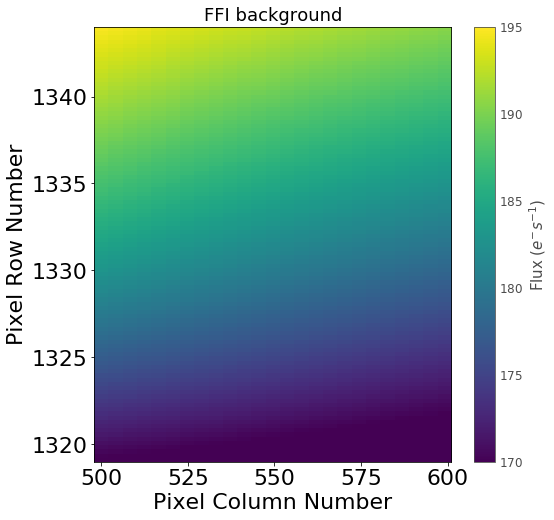

In [173]:
fig, ax = plt.subplots(figsize=(8,8))
plotutils.plot_ffi_bkg(s1c1ccd4,ax = ax, cadenceno=5605,vmin=160,vmax=420, scale='log',aspect='auto')
plt.show()

fig, ax = plt.subplots(figsize=(8,8))
plotutils.plot_ffi_bkg(s1c1ccd4,ax = ax, cadenceno=5605,vmin=170,vmax=195, cut = tpfcut, scale='linear',aspect='auto')
plt.show()

In [31]:
cut = tpfcut
cadences = s1c1ccd4['time'][()].shape[0]

bkgd = s1c1ccd4['backgrounds']['0000'][()][cut[0]:cut[1],cut[2]:cut[3]]
bkgd = np.expand_dims(bkgd, axis=0)

for c in np.arange(1,cadences):
    bkgd = np.append(bkgd,np.expand_dims(s1c1ccd4['backgrounds']['{:04d}'.format(c)][()][cut[0]:cut[1],cut[2]:cut[3]],axis = 0),axis=0)

In [ ]:
bkspline = CubicSpline(s1c1ccd4['time'][()], bkgd)
newbks = bkspline(tpf.time)

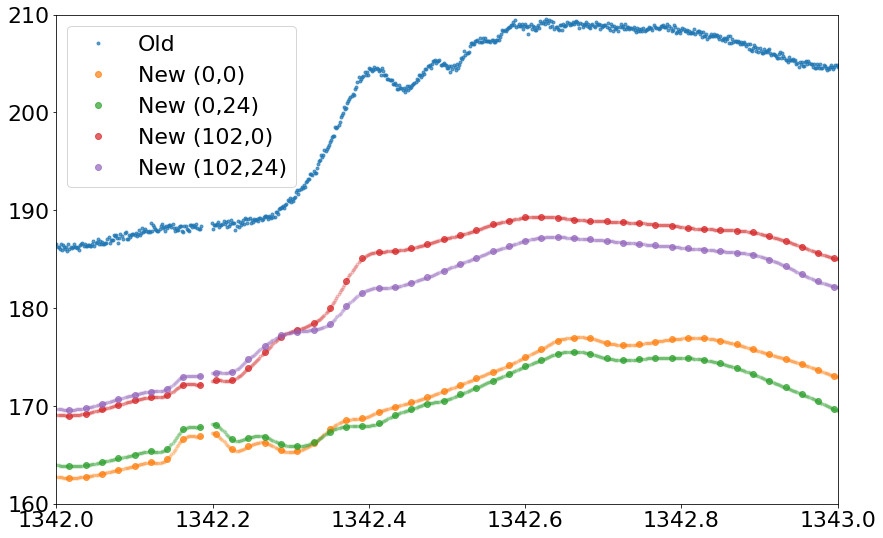

In [186]:
fig = plt.figure(figsize=(14,9))

plt.plot(tpf.time, oldbks[:,0,0],'.',alpha=0.7,label='Old')
plt.plot(tpf.time, newbks[:,0,0],'.',alpha=0.2)
plt.plot(tpf.time, newbks[:,0,24],'.',alpha=0.2)
plt.plot(tpf.time, newbks[:,102,0],'.',alpha=0.2)
plt.plot(tpf.time, newbks[:,102,24],'.',alpha=0.2)

plt.plot(s1c1ccd4['time'][()], bkgd[:,0,0],'C1o',alpha=0.7,label='New (0,0)')
plt.plot(s1c1ccd4['time'][()], bkgd[:,0,24],'C2o',alpha=0.7,label='New (0,24)')
plt.plot(s1c1ccd4['time'][()], bkgd[:,102,0],'C3o',alpha=0.7,label='New (102,0)')
plt.plot(s1c1ccd4['time'][()], bkgd[:,102,24],'C4o',alpha=0.7,label='New (102,24)')

plt.xlim(1342,1343)
plt.ylim(160,210)
plt.legend()
plt.show()

In [179]:
newnewbks = (newbks.T + np.nanmean(oldbks[:,tpf.background_mask],axis=1) - np.nanmean(oldbks[:,tpf.background_mask]) - np.nanmean(newbks[:,tpf.background_mask],axis=1) + np.nanmean(newbks[:,tpf.background_mask])).T

/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


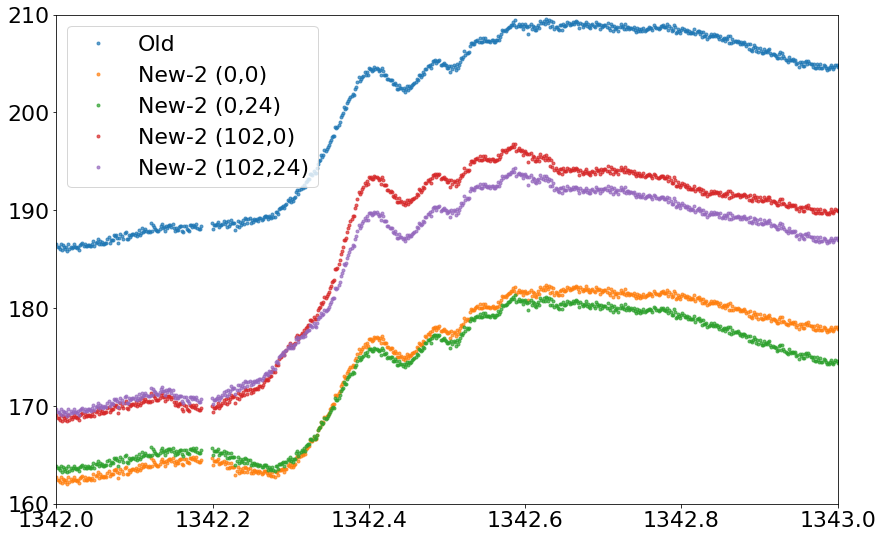

In [182]:
fig = plt.figure(figsize=(14,9))

plt.plot(tpf.time, oldbks[:,0,0],'.',alpha=0.7,label='Old')
# plt.plot(tpf.time, newbks[:,0,0],'.',alpha=0.7)
# plt.plot(tpf.time, newbks[:,0,24],'.',alpha=0.7)
# plt.plot(tpf.time, newbks[:,102,0],'.',alpha=0.7)
# plt.plot(tpf.time, newbks[:,102,24],'.',alpha=0.7)

# plt.plot(s1c1ccd4['time'][()], bkgd[:,0,0],'C1o',alpha=0.7,label='New (0,0)')
# plt.plot(s1c1ccd4['time'][()], bkgd[:,0,24],'C2o',alpha=0.7,label='New (0,24)')
# plt.plot(s1c1ccd4['time'][()], bkgd[:,102,0],'C3o',alpha=0.7,label='New (102,0)')
# plt.plot(s1c1ccd4['time'][()], bkgd[:,102,24],'C4o',alpha=0.7,label='New (102,24)')

plt.plot(tpf.time, newnewbks[:,0,0],'.',alpha=0.7,label='New-2 (0,0)')
plt.plot(tpf.time, newnewbks[:,0,24],'.',alpha=0.7,label='New-2 (0,24)')
plt.plot(tpf.time, newnewbks[:,102,0],'.',alpha=0.7,label='New-2 (102,0)')
plt.plot(tpf.time, newnewbks[:,102,24],'.',alpha=0.7,label='New-2 (102,24)')

plt.xlim(1342,1343)
plt.ylim(160,210)
# plt.axvline(1394.3)
# plt.axvline(1394.6)
plt.legend()
plt.show()

/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


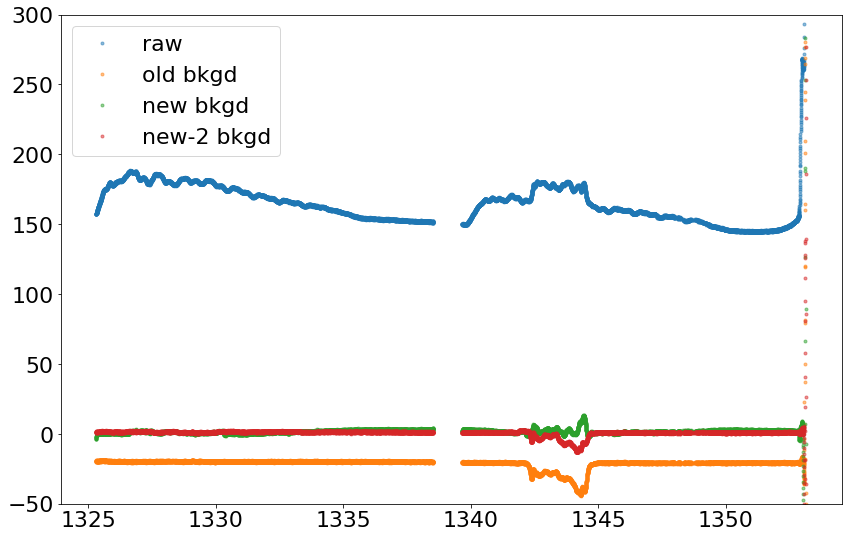

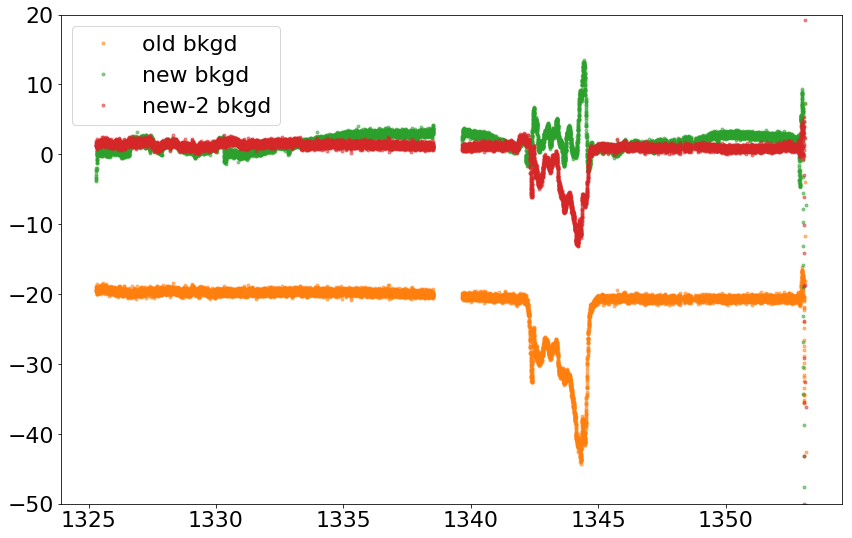

In [203]:
fig = plt.figure(figsize=(14,9))

plt.plot(tpf.time, np.nanmean(tpf.flux[:,newmask] + oldbks[:,newmask],axis=1),'.',alpha=0.5,label='raw')
plt.plot(tpf.time, np.nanmean(tpf.flux[:,newmask],axis=1),'.',alpha=0.5,label='old bkgd')
plt.plot(tpf.time, np.nanmean(tpf.flux[:,newmask] + oldbks[:,newmask] - newbks[:,newmask],axis=1),'.',alpha=0.5,label='new bkgd')
plt.plot(tpf.time, np.nanmean(tpf.flux[:,newmask] + oldbks[:,newmask] - newnewbks[:,newmask],axis=1),'.',alpha=0.5,label='new-2 bkgd')

# # plt.xlim([1334,1335])
plt.ylim(-50,300)

plt.legend()
plt.show


fig = plt.figure(figsize=(14,9))
plt.plot(tpf.time, np.nanmean(tpf.flux[:,newmask],axis=1),'.',c='C1',alpha=0.5,label='old bkgd')
plt.plot(tpf.time, np.nanmean(tpf.flux[:,newmask] + oldbks[:,newmask] - newbks[:,newmask],axis=1),'.',c='C2',alpha=0.5,label='new bkgd')
plt.plot(tpf.time, np.nanmean(tpf.flux[:,newmask] + oldbks[:,newmask] - newnewbks[:,newmask],axis=1),'.',c='C3',alpha=0.5,label='new-2 bkgd')

# # plt.xlim([1334,1335])
plt.ylim(-50,20)

plt.legend()
plt.show()

/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


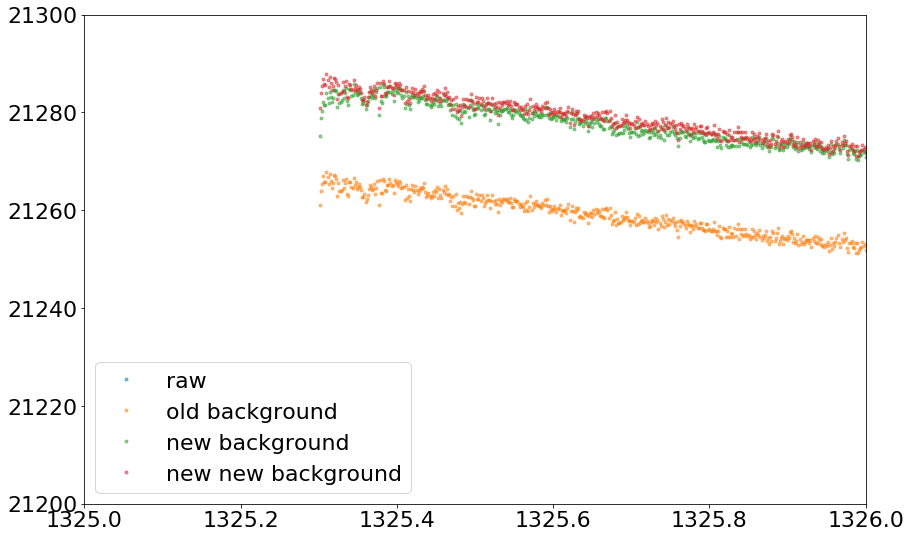

In [38]:
lc = tpf.to_lightcurve(aperture_mask=newmask)

oldbkflat = np.nansum(oldbks[:,18:19,10:11],axis=(1,2))
newbkflat = np.nansum(newbks[:,18:19,10:11],axis=(1,2))

fig = plt.figure(figsize=(14,9))


# plt.plot(tpf.time, np.nanmean(tpf.flux[:,tpf.background_mask] + oldbks[:,tpf.background_mask],axis=1),'.',alpha=0.5,label='raw')
# plt.plot(tpf.time, np.nanmean(tpf.flux[:,tpf.background_mask],axis=1),'.',alpha=0.5,label='old background')
# plt.plot(tpf.time, np.nanmean(tpf.flux[:,tpf.background_mask] + oldbks[:,tpf.background_mask] - newnewbks[:,tpf.background_mask],axis=1),'.',alpha=0.5,label='new background')

plt.plot(tpf.time, np.nanmean(tpf.flux[:,newmask] + oldbks[:,newmask],axis=1),'.',alpha=0.5,label='raw')
plt.plot(tpf.time, np.nanmean(tpf.flux[:,newmask],axis=1),'.',alpha=0.5,label='old background')
plt.plot(tpf.time, np.nanmean(tpf.flux[:,newmask] + oldbks[:,newmask] - newbks[:,newmask],axis=1),'.',alpha=0.5,label='new background')
plt.plot(tpf.time, np.nanmean(tpf.flux[:,newmask] + oldbks[:,newmask] - newnewbks[:,newmask],axis=1),'.',alpha=0.5,label='new new background')


# plt.plot(tpf.time, np.nanmean(oldbks[:,tpf.background_mask],axis=1) - np.nanmean(newbks[:,tpf.background_mask],axis=1),'.',alpha=0.5,label='old background')
# plt.plot(tpf.time, ,'.',alpha=0.5,label='old background')
# plt.plot(tpf.time, newnewbks[:,tpf.background_mask],'.',alpha=0.1)


plt.xlim(1325,1326)
# plt.ylim(-50,30)

# # plt.xlim([1334,1335])
plt.ylim([21200,21300])
plt.legend()
plt.show()

/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


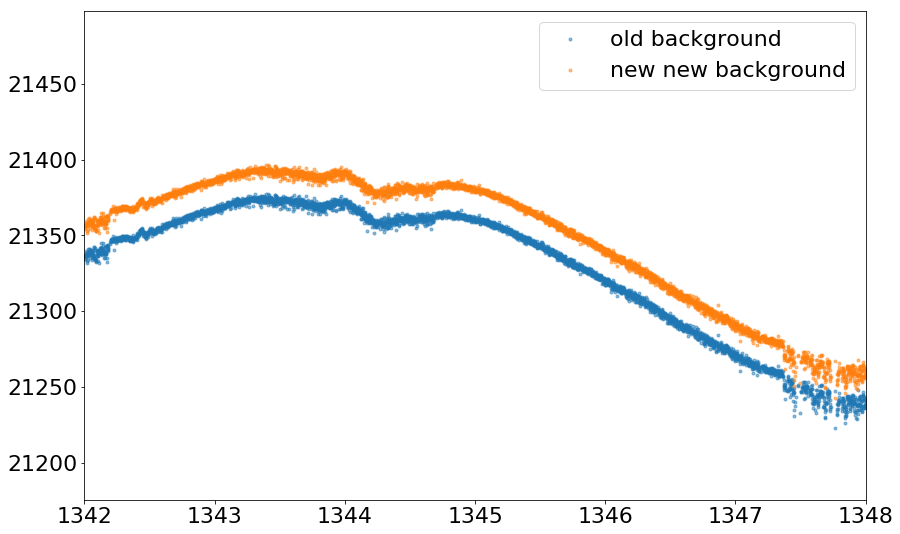

In [22]:
fig = plt.figure(figsize=(14,9))

# plt.plot(tpf.time, np.nanmean(tpf.flux[:,tpf.background_mask] + oldbks[:,tpf.background_mask],axis=1),'.',alpha=0.5,label='raw')
# plt.plot(tpf.time, np.nanmean(tpf.flux[:,tpf.background_mask],axis=1),'.',alpha=0.5,label='old background')
# plt.plot(tpf.time, np.nanmean(tpf.flux[:,tpf.background_mask] + oldbks[:,tpf.background_mask] - newnewbks[:,tpf.background_mask],axis=1),'.',alpha=0.5,label='new background')

# plt.plot(tpf.time, np.nanmean(tpf.flux[:,tpf.pipeline_mask] + oldbks[:,tpf.pipeline_mask],axis=1),'.',alpha=0.5,label='raw')
plt.plot(tpf.time, np.nanmean(tpf.flux[:,newmask],axis=1),'.',alpha=0.5,label='old background')
# plt.plot(tpf.time, np.nanmean(tpf.flux[:,tpf.pipeline_mask] + oldbks[:,tpf.pipeline_mask] - newbks[:,tpf.pipeline_mask],axis=1),'.',alpha=0.5,label='new background')
plt.plot(tpf.time, np.nanmean(tpf.flux[:,newmask] + oldbks[:,newmask] - newnewbks[:,newmask],axis=1),'.',alpha=0.5,label='new new background')


# plt.plot(tpf.time, np.nanmean(oldbks[:,tpf.background_mask],axis=1) - np.nanmean(newbks[:,tpf.background_mask],axis=1),'.',alpha=0.5,label='old background')
# plt.plot(tpf.time, ,'.',alpha=0.5,label='old background')
# plt.plot(tpf.time, newnewbks[:,tpf.background_mask],'.',alpha=0.1)


plt.xlim(1342,1348)
# plt.ylim(-50,30)

# # plt.xlim([1334,1335])
# plt.ylim([140,230])
plt.legend()
plt.show()

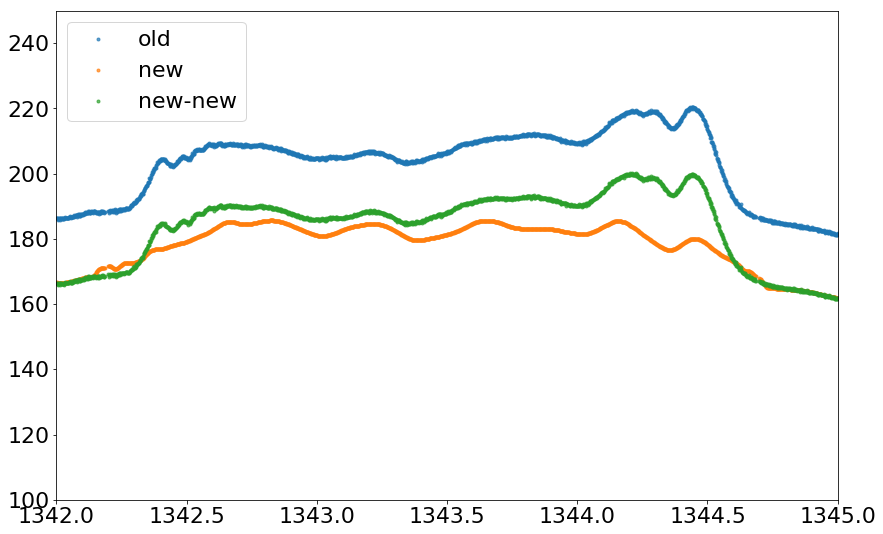

In [77]:
fig = plt.figure(figsize=(14,9))
oldbks = tpf.flux_bkg
plt.plot(tpf.time, oldbks[:,50,12],'.',alpha=0.7,label='old')
plt.plot(tpf.time, newbks[:,50,12],'.',alpha=0.7,label='new')
plt.plot(tpf.time, newnewbks[:,50,12],'.',alpha=0.7,label='new-new')

plt.ylim(100,250)
plt.legend()

plt.xlim(1342,1345)
# plt.ylim([140,230])


plt.show()

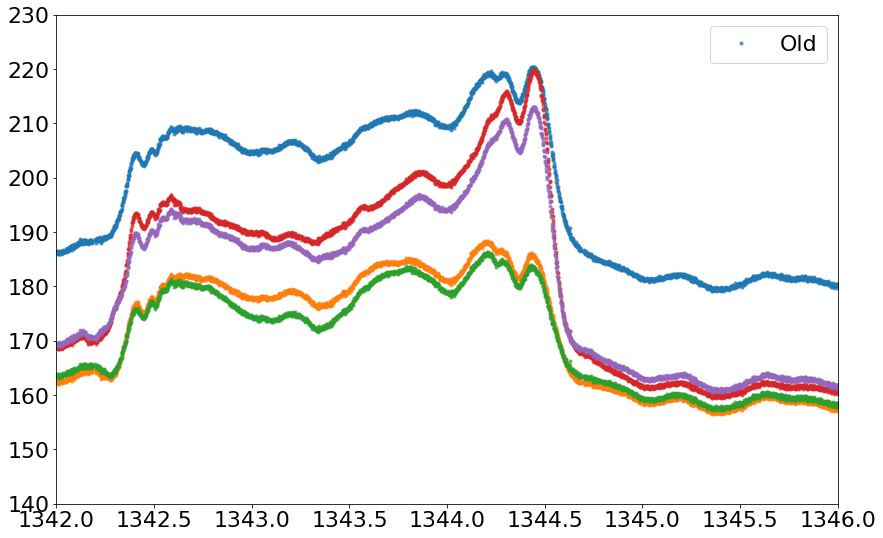

In [121]:
fig = plt.figure(figsize=(14,9))

plt.plot(tpf.time, oldbks[:,0,0],'.',alpha=0.7,label='Old')
# plt.plot(tpf.time, newbks[:,0,0],'.',alpha=0.7)
# plt.plot(tpf.time, newbks[:,0,24],'.',alpha=0.7)
# plt.plot(tpf.time, newbks[:,102,0],'.',alpha=0.7)
# plt.plot(tpf.time, newbks[:,102,24],'.',alpha=0.7)

# plt.plot(s1c1ccd4['time'][()], bkgd[:,0,0],'C1o',alpha=0.7,label='New (0,0)')
# plt.plot(s1c1ccd4['time'][()], bkgd[:,0,24],'C2o',alpha=0.7,label='New (0,24)')
# plt.plot(s1c1ccd4['time'][()], bkgd[:,102,0],'C3o',alpha=0.7,label='New (102,0)')
# plt.plot(s1c1ccd4['time'][()], bkgd[:,102,24],'C4o',alpha=0.7,label='New (102,24)')

plt.plot(tpf.time, newnewbks[:,0,0],'.',alpha=0.7)
plt.plot(tpf.time, newnewbks[:,0,24],'.',alpha=0.7)
plt.plot(tpf.time, newnewbks[:,102,0],'.',alpha=0.7)
plt.plot(tpf.time, newnewbks[:,102,24],'.',alpha=0.7)

plt.xlim(1342,1346)
plt.ylim(140,230)
# plt.axvline(1394.3)
# plt.axvline(1394.6)
plt.legend()
plt.show()

## Before

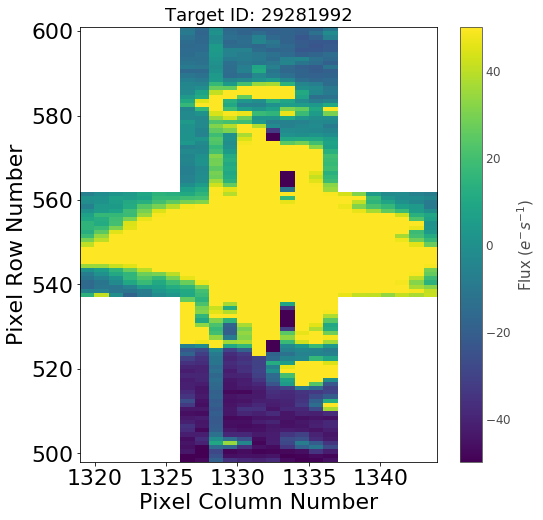

In [25]:
tpf.flux_bkg[:,:,:] = oldbks[:,:,:]
fig, ax = plt.subplots(figsize=(8,8))
tpf.plot(ax = ax, cadenceno=84061, scale='linear',vmin=-50,vmax=50,aspect='auto')
plt.show()

# fig = plt.figure(figsize=(14,9))
# plt.plot(tpf.time, tpf.flux_bkg[:,0,0],'o',alpha=0.7)
# plt.plot(tpf.time, tpf.flux_bkg[:,102,24],'o',alpha=0.7)
# plt.xlim(1340,1345)
# plt.ylim(150,250)
# plt.show()

## After

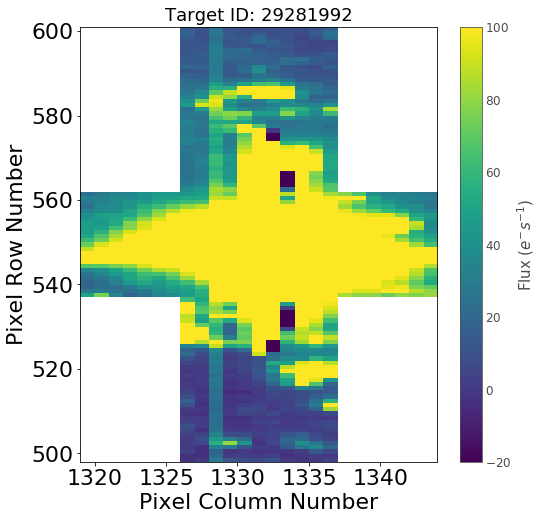

In [28]:
tpf.flux_bkg[()] = newbks[()]
fig, ax = plt.subplots(figsize=(8,8))
plotutils.plot_new(tpf,newbks, ax = ax, cadenceno=84061, scale='linear',vmin=-20,vmax=100,aspect='auto')
plt.show()

## After after

NameError: name 'patches' is not defined

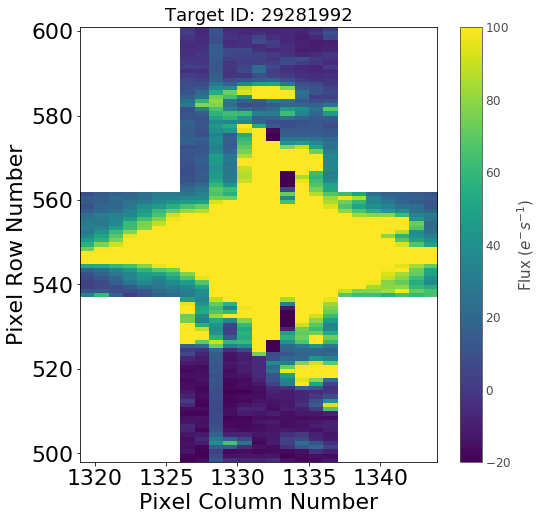

In [195]:
# tpf.flux_bkg[()] = newbks[()]
fig, ax = plt.subplots(figsize=(8,8))
plotutils.plot_new(tpf,newnewbks, ax = ax, cadenceno=84061, scale='linear',vmin=-20,vmax=100,aspect='auto',aperture_mask=newmask)
plt.show()

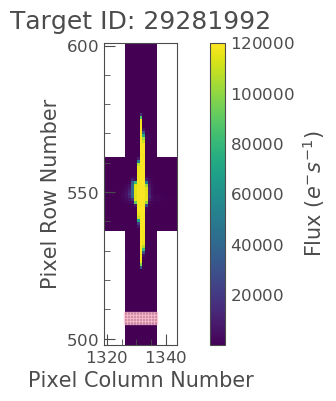

In [199]:
newmask = np.ones((tpf.flux.shape[1],tpf.flux.shape[2]),dtype='bool')

xx, yy = np.meshgrid(np.arange(newmask.shape[0]),np.arange(newmask.shape[1]))

ymin = 7
ymax = 10
xmin = 7
xmax = 17

m1 = np.logical_or((xx>ymax).T,(xx<ymin).T)
m2 = np.logical_or((yy>xmax).T,(yy<xmin).T)

m3 = np.logical_or(m1,m2)

newmask[m3] = False

# ymin = 20
# ymax = 80
# ymin2 = 40
# ymax2 = 60
# xmin = 0
# xmax = 24
# xmin2 = 10
# xmax2 = 14

# m1 = np.logical_or((xx>ymax).T,(xx<ymin).T)
# m2 = np.logical_or((yy>xmax).T,(yy<xmin).T)
# m3 = np.logical_or((xx>ymax2).T,(xx<ymin2).T)
# m4 = np.logical_or((yy>xmax2).T,(yy<xmin2).T)
# m5 = np.logical_or(m1,m4)
# m6 = np.logical_or(m2,m3)

# m7 = np.logical_and(m5,m6)
# # m8 = np.logical_and((rr>rmax).T,m7)
# # # m6 = np.logical_or((yy>xmax2).T,(yy<xmin2).T)
# # # m7 = np.logical_and(m5,m6)

# newmask[m7] = False

tpf.plot(cadenceno=84023,aperture_mask=newmask)

/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/tim/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


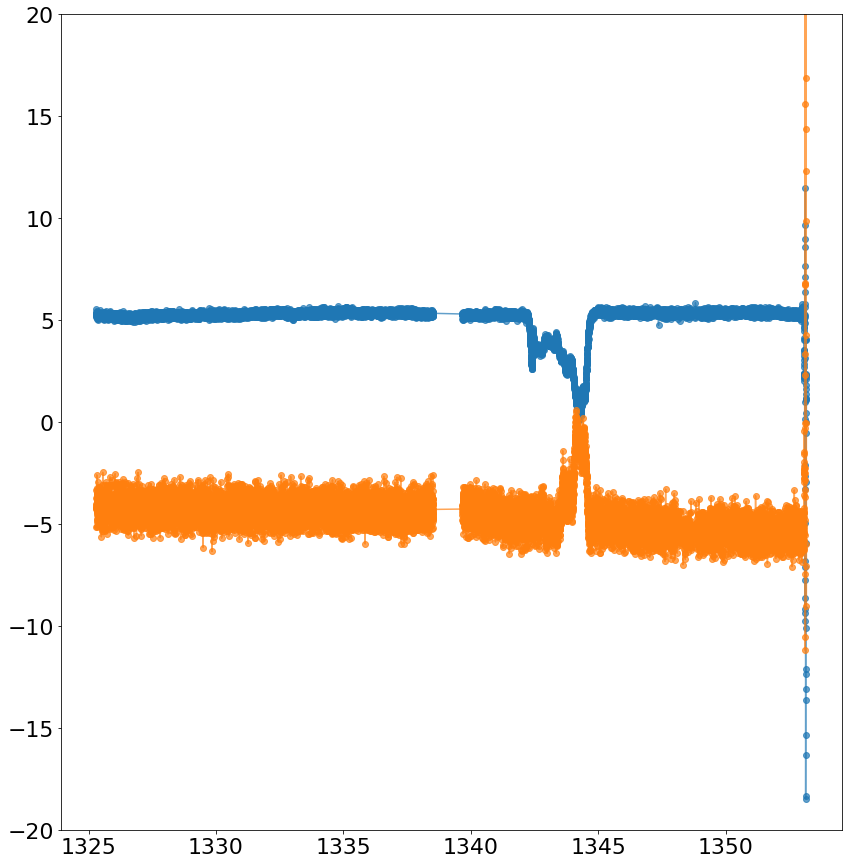

In [117]:
fig = plt.figure(figsize=(14,15))

# plt.plot(tpf.time, tpf.flux[:,tpf.background_mask][:,::12] + oldbks[:,tpf.background_mask][:,::12],'o-',alpha=0.7)

plt.plot(tpf.time, np.nanmean(tpf.flux[:,tpf.background_mask],axis=1),'o-',alpha=0.7)
plt.plot(tpf.time, np.nanmedian(tpf.flux[:,tpf.background_mask],axis=1),'o-',alpha=0.7)

# plt.xlim(1343,1344)
plt.ylim([-20,20])
plt.show()